### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
from math import log
import seaborn as sns

---
### Upload Dataset

In [2]:
X_und = pd.read_csv("cleaned_rain_x.csv")
y_und = pd.read_csv("cleaned_rain_y.csv")

---
### Split into testing and training data

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.25, random_state=42)

---
### Create 'Total' Train DataFrame

In [4]:
x_train_total = pd.concat([x_train, y_train], axis=1)
x_train_total.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
x_train_total.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,RainTomorrow
22845,-0.925855,-1.343428,0.213256,0.145445,1.220578,0.274457,0.183993,0.755625,1.500069,0.894962,...,1.088941,-0.929551,-0.843587,-0.839679,1.169532,-0.846416,-0.822150,1.097495,1.094764,0
42446,1.314874,0.856220,0.352357,0.376646,0.437868,0.382385,1.842494,-0.917119,-0.666636,0.499156,...,1.088941,1.075788,1.185414,-0.839679,-0.855043,-0.846416,-0.822150,-0.911166,1.094764,1
5989,0.610645,0.741206,-0.273598,0.376646,0.214237,0.166529,0.137924,-0.533211,-0.666636,0.894962,...,-0.918324,-0.929551,-0.843587,1.190932,1.169532,-0.846416,1.216322,1.097495,-0.913439,0
39347,-0.077579,0.223641,0.491458,-1.126157,-1.462998,0.382385,-0.645257,-0.231568,-0.666636,0.499156,...,-0.918324,-0.929551,-0.843587,1.190932,1.169532,-0.846416,1.216322,1.097495,-0.913439,1
31998,-1.117918,-0.811487,-0.690902,-0.779357,0.214237,1.299772,-0.092423,1.797663,1.500069,-1.479872,...,-0.918324,1.075788,-0.843587,-0.839679,1.169532,-0.846416,1.216322,1.097495,-0.913439,1


---
# Evaluators
---

In [5]:
def conf(TP, FP, TN, FN):
    cf = np.array([[TN, FP], [FN, TP]])
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf.flatten()/np.sum(cf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf, annot=labels, fmt='', 
                cmap=sns.diverging_palette(230, 20, center='light'))

In [6]:
def TF(y_actu, y_pred):
    TP = np.sum(np.logical_and(y_pred == 1, y_actu == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y_actu == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y_actu == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_actu == 1))
    conf(TP, FP, TN, FN)
    return TP, FP, TN, FN

In [7]:
def eval(models, test_x, test_y):
    for m in models:
        model = m[0]
        TP, FP, TN, FN = TF(test_y, np.array(model.predict(test_x)))
        acc = (TP + TN) / (TP + TN + FP + FN)
        pre = TP / (TP + FP)
        re = TP / (FN + TP)
        f1 = (2 * (pre * re)) / (pre + re)
        scoring = {m[1]:{"Accuracy":acc, "Precision":pre,"Recall":re,"F1":f1}}
    return pd.DataFrame(scoring)

---
# Gradient Descent Logistic Regression Implementation
---

In [8]:
class GDLogReg:

      #### Helper Functions ##########

    def add_const(self, dataframe):
        n, k = dataframe.shape
        ones = np.ones((n, 1))
        return np.concatenate([ones, dataframe], axis = 1)

    def sigmoid(self, t):
        return 1/(1 + np.exp(-t))

    def ce(self, pred, y):
        y = y.to_numpy()
        total = 0
        for i in range(len(pred)):
            if pred[i] == 0:
                x = 0.0000001
            else:
                x = pred[i]
            total += y[i] * log(x)
        return -total

      ################################

    def __init__(self):
        self.theta = None
        self.fit()

    def fit(self, X=x_train, y=y_train["RainTomorrow"], l_rate=.01, epochs=101):
        X = self.add_const(X)

        n, d = X.shape

        # 1. initialize theta at random
        self.theta = np.zeros((d, ))

        # 2. repeat until stopping conditions
        for epoch in range(epochs):
          
            theta_old = self.theta
          
            prediction = self.sigmoid(X @ theta_old)
          
            gradient = np.matmul(X.T, (prediction-y)) / n
          
            # 3. update theta
            self.theta -= l_rate * gradient

            cross_entropy = self.ce(prediction, y)
        return self

    def predict(self, X=x_test):
        if self.theta is None:
            raise RuntimeError('Model has not been fit yet')
        X = self.add_const(X)
        return np.rint(self.sigmoid(X @ self.theta)).astype(int)

---
# RESULTS
---

<ipython-input-8-85b5b8bb8adf>:11: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-t))


,Logistic Regression
Accuracy,0.503960
F1,0.670177
Precision,0.503960
Recall,1.000000


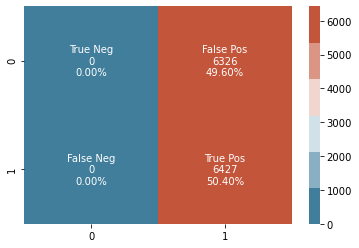

In [9]:
LR = GDLogReg()
eval([[LR, "Logistic Regression"]], x_test, y_test['RainTomorrow'])